# <font color=darkcyan> Variational inference </font>
#### <font color=darkorange>Basics: Evidence Lower Bound (ELBO) & Coordinate Ascent Variational Inference (CAVI) </font>

In [1]:
"""""""""""""""""
Required packages
"""""""""""""""""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

<font color=darkred>Mixture of Gaussian distributions.</font>

Following ``Variational Inference: A Review for Statisticians, Blei et al; (2017)``, consider a Bayesian mixture of unit-variance univariate Gaussians. 

There are $K$ mixture components, each component $k$ of the mixture is a Gaussian distribution with mean $\mu_k$ and variance 1. The random variables $\mu = (\mu_k)_{1\leqslant k \leqslant K}$ are assumed to be independent and identically distributed (i.i.d.) with Gaussian distribution with mean 0 and variance $\sigma^2$. The weight of each mixture component $k$ written $\omega_k$. Conditionally on $\mu$, the observations $(X_i)_{1\leqslant i\leqslant n}$ are assumed to be i.i.d. with probability density:

$$
p(x|\mu) = \sum_{k=1}^K \omega_k \varphi_{\mu_k,1}(x)\,,
$$

where $\varphi_{\mu_k,\sigma^2}$ is the Gaussian probability function with mean $\mu_k$ and variance $\sigma^2$. The likelihood is then given by:

$$
p(x_1,\cdots,x_n) = \int p(x_1,\cdots,x_n|\mu) p(\mu) \mathrm{d} \mu = \int \prod_{i=1}^n p(x_i|\mu) p(\mu) \mathrm{d} \mu = \int \prod_{i=1}^n \left(\sum_{k=1}^K \omega_k \varphi_{\mu_k,1}(x_i)\right) p(\mu) \mathrm{d} \mu
$$

Application with $K= 5$, $\sigma^2 = 5$, $\omega_k = 1/K$ for all $1\leqslant k \leqslant K$.

<font color=darkcyan> **Note charles**
The more numpythonic way of sampling data is working with arrays directly instead of loops. It's faster, and in many cases will be mandatory for automatic differentiation and fast parallelisation.

In [2]:
# Sample data
np.random.seed(2)
K  = 6 # number of mixture components
#sigma = 4
sigma2 = np.array([[20,2],
                [2,10]])

dim = 2
mu = np.random.multivariate_normal([0,0], sigma2, K)
#mu = np.random.normal(0, sigma, size=(K, dim)) # means of the distribution in each cluster
n_samples = 2000 # number of samples

In [3]:
mu

array([[ 1.88070076,  0.1845129 ],
       [ 8.50905882,  6.81827182],
       [ 8.44482874, -1.03170832],
       [-1.49932511, -4.22106096],
       [ 5.22348383, -1.8644742 ],
       [-3.78899286,  6.50854282]])

In [4]:
idx = np.random.randint(0,K,n_samples)
np.random.seed(0)
# here mu[idx], when idx is an integer array, returns an array of the mu values indexed by idx
X = np.random.normal(0, 1, size=(n_samples, dim)) + mu[idx]

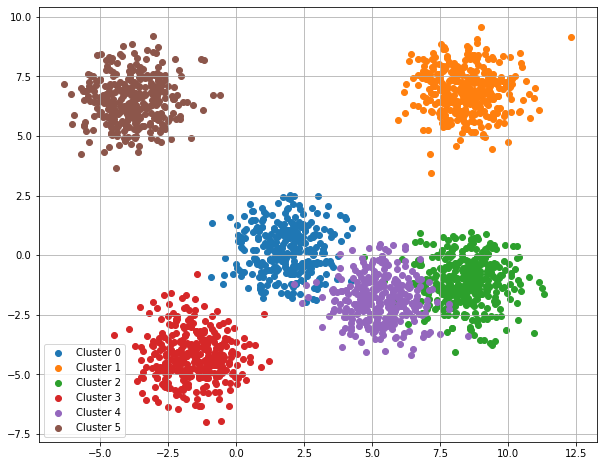

In [5]:
plt.figure(figsize=(10,8))
plt.grid(True)
for i in range(K):
  plt.scatter(X[idx == i, 0], X[idx == i,1], label=f"Cluster {i}")
  plt.legend()

Our aim is to approximate the posterior distribution $p(\mu,c|x)$ where $c = (c_1,\cdots,c_n)$ are the mixture components of the observations.  The mean-field variational family is described as follows:

$$
q(\mu,c) = \prod_{k=1}^K \varphi_{m_k,s_k}(\mu_k)\prod_{i=1}^n \mathrm{Cat}_{\phi_i}(c_i)\,, 
$$

which means that:

- $\mu$ and $c$ are independent.
- $(\mu_{k})_{1\leqslant k \leqslant K}$ are independent with Gaussian distribution with means $(m_{k})_{1\leqslant k \leqslant K}$ and variances $(s_{k})_{1\leqslant k \leqslant K}$.
- $(c_{i})_{1\leqslant i \leqslant n}$ are independent with multinomial distribution with parameters $(\phi_i)_{1\leqslant i \leqslant n}$: $q(c_i=k) = \phi_i(k)$ for $1\leqslant k \leqslant K$. 

Write $\mathcal{D}$ the family of such distributions when $(m_{k})_{1\leqslant k \leqslant K}\in \mathbb{R}^K$, variances $(s_{k})_{1\leqslant k \leqslant K}\in (\mathbb{R}_+^*)^K$ and $(\phi_i)_{1\leqslant i \leqslant n}\in \mathcal{S}_K^n$ where $\mathcal{S}_K$ is the $K$-dimensional probability simplex. 

The objective is now to find the
"best candidate" in $\mathcal{D}$ to approximate $p(\mu,c|x)$, i.e. the one ``which minimizes the following KL divergence``:

$$
q^* = \mathrm{Argmin}_{q\in\mathcal{D}} \mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right)\,.
$$

Note that
\begin{align*}
\mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right) &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c|x)]\,,\\
 &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c,x)]+\log p(x)\,,\\
&= -\mathrm{ELBO}(q)+\log p(x)\,,
\end{align*}

where the ``Evidence Lower Bound`` (ELBO) is

$$
\mathrm{ELBO}(q) = -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,.
$$

Therefore, ``minimizing the KL divergence`` boils down to maximizing the ELBO, where $\log p(x)\geqslant \mathrm{ELBO}(q)$.

The complexity of the family $\mathcal{D}$ determines the complexity of the optimization.

<font color=darkred>Generic CAVI algorithm.</font>

The CAVI algorithm updates iteratively the marginal distribution of each variables, for instance, 

\begin{align*}
\mathrm{ELBO}(q) &= -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,,\\
&= -\mathbb{E}_{q_{\mu_k}}[\log q_{\mu_k}(\mu_k)] + \mathbb{E}_{q_{\mu_k}}[\mathbb{E}_q[\log p(\mu,c,x)|\mu_k]] \,,\\
&= -\mathbb{E}_{q_{\mu_k}}[\log q_{\mu_k}(\mu_k)] + \mathbb{E}_{q_{\mu_k}}[\mathbb{E}_{q_{\bar \mu_k}}[\log \tilde p_k(\mu_k|x)]] + C \,,\\
\end{align*}


Therefore, the algorithm computes iteratively for all $1\leqslant k \leqslant K$,

$$
q(\mu_k) \propto \mathrm{exp}\left(\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_k(\mu_k|x)]\right)
$$

and, similarly,  for all $1\leqslant i \leqslant n$,

$$
q(c_i) \propto \mathrm{exp}\left(\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)]\right)\,,
$$

where 

- $\tilde p_i(c_i|x)$ is the conditional distribution of $c_i$ given the observations and all the other parameters and $\tilde p_k(\mu_k|x)$ is the conditional distribution of $\mu_k$ given the observations and all the other parameters.

- $\mathbb{E}_{\tilde q_z}$ is the expectation under the variational law of all parameters except $z$.

<font color=darkred>Application to the mixture of Gaussian distributions.</font>

As $\tilde p_i(c_i|x)$ be the conditional distribution of $c_i$ given the observations and the other parameters.

$$
\tilde p_i(c_i|x) \propto p(c_i)p(x_i|c_i,\mu) \propto p(c_i)\prod_{k=1}^K \left(\varphi_{\mu_k,1}(x_i)\right)^{1_{c_i=k}}\,. 
$$

Therefore,

$$
\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)] = \log p(c_i) + \sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[\log \varphi_{\mu_k,1}(x_i)]
$$

and

\begin{align*}
\mathrm{exp}\left(\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)]\right) &\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[-(x_i-\mu_k)^2/2]\right)\,\\
&\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[-(x_i-\mu_k)^2/2]\right)\,.
\end{align*}

The update is then written:

$$
\varphi_i(k) \propto p(c_i=k) \mathrm{exp}\left(m_k x_i - \frac{m^2_k + s_k}{2}\right)\,.
$$

* In dimension m
$$
q(c_i=k) \propto p(c_i=k) \exp(x_i^{T}.m_k - \frac{m_k^{T}.m_k + \operatorname{tr}(\Sigma_{k}) }{2})
$$

<font color=darkred> Update of $(\phi_i)_{1\leqslant i \leqslant n}$ using CAVI.</font>

In [6]:
def CAVI_update_phi(X,m,s2):
    
    first_term_mean = (X @ mu.T)

    second_term_mean = -(np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1))/2
    second_term_mean = second_term_mean.reshape(1,-1)
    x = first_term_mean + second_term_mean
    x = x - x.max(axis=1, keepdims=True) ## avoid pb of overflow

    phi = np.exp(x)
    phi = phi / phi.sum(1, keepdims=True)
    
    return phi

As $\tilde p_k(\mu_k|x)$ be the conditional distribution of $\mu_k$ given the observations and the other parameters.

$$
\tilde p_k(\mu_k|x) \propto p(\mu_k)\prod_{i=1}^np(x_i|c_i,\mu) \propto p(\mu_k)\prod_{i=1}^n p(x_i|\mu,c_i)\,. 
$$

Therefore,

$$
\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_k(\mu_k|x)] = \log p(\mu_k) + \sum_{i=1}^n \mathbb{E}_{\tilde q_{\mu_k}}[\log p(x_i|\mu,c_i)]
$$

and

\begin{align*}
\mathrm{exp}\left(\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_i(c_i|x)]\right) &\propto p(\mu_k) \mathrm{exp}\left(\sum_{i=1}^n\sum_{k=1}^K  \mathbb{E}_{\tilde q_{\mu_k}}[1_{c_i=k}\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto p(\mu_k) \mathrm{exp}\left(\sum_{i=1}^n \phi_i(k) \mathbb{E}_{\tilde q_{\mu_k}}[\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto \mathrm{exp}\left(-\frac{\mu_k^2}{2\sigma^2}-\frac{1}{2}\sum_{i=1}^n \phi_i(k)(x_i-\mu_k)^2\right)\,,\\
&\propto \mathrm{exp}\left(-\frac{\mu_k^2}{2\sigma^2}+\sum_{i=1}^n \phi_i(k)x_i\mu_k - \frac{1}{2}\sum_{i=1}^n \phi_i(k)\mu^2_k\right)\,.
\end{align*}

The update is then written:

$$
m_k = \frac{\sum_{i=1}^n \phi_i(k)x_i}{1/\sigma^2 + \sum_{i=1}^n \phi_i(k)}\quad\mathrm{and}\quad s_k = \frac{1}{1/\sigma^2 + \sum_{i=1}^n \phi_i(k)}\,. 
$$

* In dimension m
$$
\Sigma_{k}^{-1} = \Sigma^{-1} + \sum_{i=1}^n \phi_i(k)I_{m}
\quad\mathrm{and}\quad m_k = \Sigma_{k}(\sum_{i=1}^n \phi_i(k)x_i)
$$

For the elbo
$$
ELBO = \sum_{i=1}^n \frac{\log(\det(\Sigma_{k}))-(m_k^{T}\Sigma^{-1}m_k + \operatorname{tr}(\Sigma_{k}\Sigma^{-1}))}{2} + \sum_{i=1}^n\sum_{k=1}^K q_i(k)[m_k^{T}.x_i - \log(q_i(k)) -  \frac{m_k^{T}.m_k + \operatorname{tr}(\Sigma_{k})}{2} ]
$$



<font color=darkred> Update of $(m_{k})_{1\leqslant k \leqslant K}$ and $(s_{k})_{1\leqslant k \leqslant K}$ using CAVI.</font>

In [7]:
def CAVI_update_mu_s2(X,phi,sigma2, K, dim):

    p = phi.T.sum(axis=1, keepdims=True)
    s2_inv = np.linalg.inv(sigma2) + p.reshape(-1,1)[:,:,None]*np.identity(dim)
    s2 = np.linalg.inv(s2_inv)

    a = (phi.T @ X)
    m  = (s2 @ a[:,:,None])[:,:,0]
    return m, s2

In [8]:
def elbo(X,phi,m,s2,sigma2):
  t1 = np.linalg.det(s2).reshape(-1,1)[:,:,None] - (m[:,None,:] @ (np.linalg.inv(sigma2)@m[:,:,None] + (np.linalg.inv(sigma2) @ s2).trace(axis1=-2, axis2=-1)[:,None,None]))
  t1 = t1.sum()/2

  second_term = -(np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1))/2
  second_term = second_term.reshape(1,-1)
  second_term = (X @ m.T - np.log(phi)) + second_term

  second_term = second_term*phi
  t2 = second_term.sum()
  return t1 + t2

In [9]:
def CAVI_mixture_Gaussian(X,m, s2, phi, sigma2, max_iter = 500, epsilon = 1e-2):
  elbos  = [elbo(X, phi, m, s2,sigma2)]
  m_est  = [m]
  s2_est = [s2]
  phi_est = [phi]

  k, dim = phi.shape[1] , m.shape[1] 
  for it in range(1, max_iter+1):

      phi   = CAVI_update_phi(X,m,s2)
      m, s2 = m, s2 = CAVI_update_mu_s2(X,phi,sigma2, K, dim)
      m_est.append(m)
      s2_est.append(s2)
      phi_est.append(phi)
      
      elbos.append(elbo(X,phi,m,s2,sigma2))

      if np.abs(elbos[-2] - elbos[-1]) <= epsilon:
          break

  return elbos, m_est, s2_est, phi_est

<font color=darkred> Run the algorithm.</font>

In [10]:
# Initialization
phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, n_samples)
m_init = np.random.normal(0, 10, (K,dim))
s2_init = np.random.normal(0,10,(K,dim, dim))
sigma2_init = np.array([[1, 0], [0, 1]])
print(phi_init.shape)
print(s2_init.shape)
print(m_init.shape)

(2000, 6)
(6, 2, 2)
(6, 2)


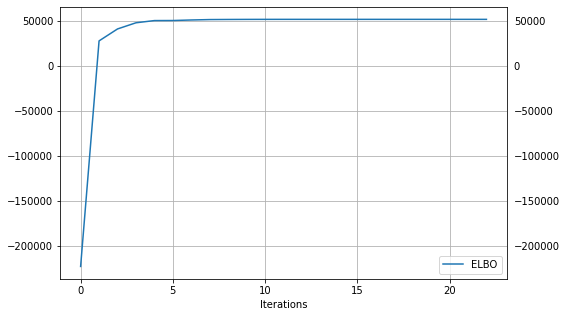

In [11]:
fig = plt.figure(figsize=(8,5))
elbos, m_est, s2_est, phi_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, sigma2_init)
plt.plot(np.array(elbos),label = 'ELBO')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Iterations')
plt.legend();

In [12]:
s2_est[-1]

array([[[0.00319948, 0.        ],
        [0.        , 0.00319948]],

       [[0.0028573 , 0.        ],
        [0.        , 0.0028573 ]],

       [[0.00274578, 0.        ],
        [0.        , 0.00274578]],

       [[0.0029404 , 0.        ],
        [0.        , 0.0029404 ]],

       [[0.00330925, 0.        ],
        [0.        , 0.00330925]],

       [[0.00296736, 0.        ],
        [0.        , 0.00296736]]])

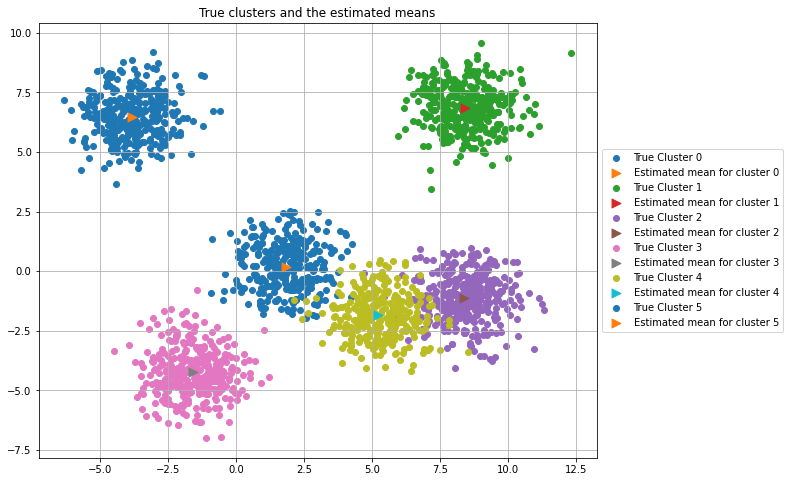

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
 
# Posterior distribution of the means in each group

plt.figure(figsize=(10,8))
plt.grid(True)
for i in range(K):
  plt.scatter(X[idx == i, 0], X[idx == i,1], label=f"True Cluster {i}")
  plt.legend()
  cov, mean = s2_est[-1][i], m_est[-1][i,:] ## Latest value of the estimators
  plt.scatter(mean[0], mean[1], s=80, marker=">", label=f"Estimated mean for cluster {i}")
  #print(cov.shape, mean.shape)
  #data = np.random.multivariate_normal(mean, cov, 100)
  # x, y = data[:,0], data[:,1]
  #sns.kdeplot(x, y, cmap="Blues", shade=True, thresh=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("True clusters and the estimated means")
plt.show()

It's normal to have small values in the estimator of the covariance matrix of the posterior distribution of the means (in the mean-field ) in each groupe.

- Once we have a fitted variational density, we can use it as we
would use the posterior. For example, we can obtain a posterior decomposition of the data. We assign points to their most likely mixture assignment
$c_i = \arg \underset{1 \leq k \leq K} \max  ϕ_i(k)$ and estimate cluster
means with their variational means $m_k$.

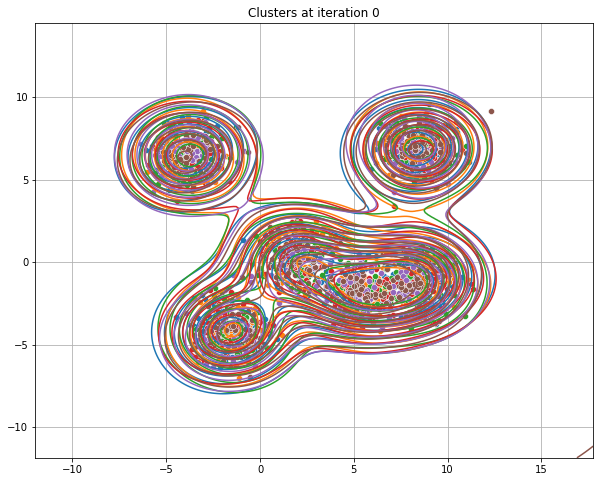

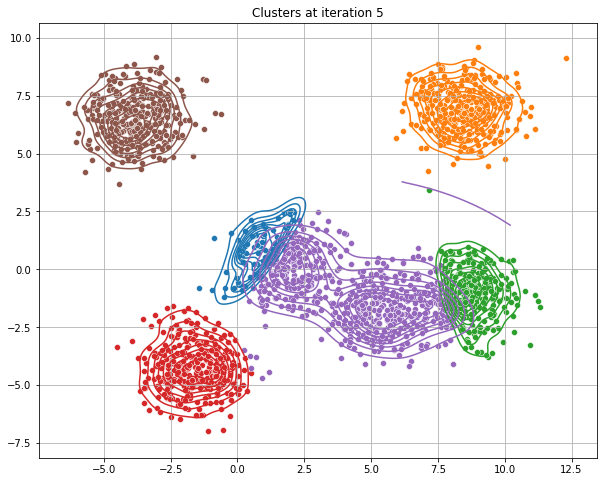

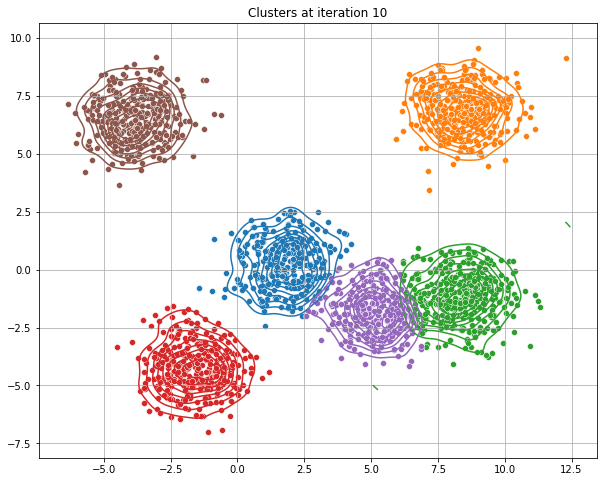

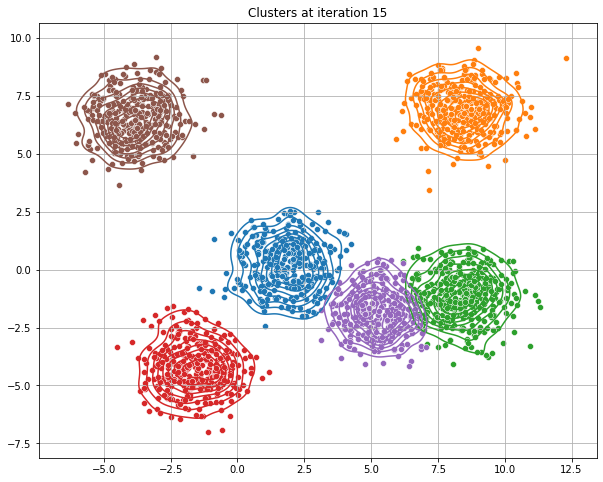

In [15]:
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


for j in range(0, len(phi_est)):
  if j%5 == 0  and j < 20:
    plt.figure(figsize=(10,8))
    plt.grid(True)
    C = phi_est[j].argmax(axis=1)
    for i in list(set(C)):
      # cov, mean = s2_est[j][i], m_est[j][i,:]
      #plt.scatter(mean[0], mean[1], s=80, marker=">", label=f"Estimated mean for cluster {i}")
      sns.kdeplot(X[C==i, 0], X[C==i, 1], thresh=0)
      sns.scatterplot(X[C == i, 0], X[C == i,1])
      plt.title(f"Clusters at iteration {j}")
      plt.plot()

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
ax.grid()
plt.close()

def h(j):
  C = phi_est[j].argmax(axis=1)
  ax.scatter(X[:, 0], X[:,1], c=C)
  ax.set_title(f"Clusters at iteration {j}")

In [17]:
from IPython.display import HTML
from matplotlib import animation, rc

In [ ]:
#plt.grid()
anim = animation.FuncAnimation(fig, h, len(phi_est), repeat = False, interval=5)
rc('animation', html='jshtml')
anim

In [ ]:
## get clusters
from sklearn.metrics.cluster import adjusted_rand_score

C = phi_est[-1].argmax(axis=1)
score = adjusted_rand_score(labels_true=idx, labels_pred=C)
print(f"Quality of the clustering: {round(score, 3)}")

Quality of the clustering: 0.86
